In [1]:
import os
import time
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

2022-03-15 22:52:35.604020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 22:52:35.608304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 22:52:35.608566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from main_classes.ParamsCreator import (
    DataParams,
    LabelsParams,
    TimeseriesParams,
    ModelParams,
    ParamsParser
)

from main_classes.ModelCreator import (
    create_model_lstm,
    create_model_attention,
    SALICONtf
)

from main_classes.ModelProcessor import (
    train_model,
    prediction_n_step, 
    model_mc_dropout
)

from main_classes.DataProcessor import DataProcessor

from utils.process_methods import process_foveatedImg
from utils.process_helpers import create_real_dict, adjust_indexes

In [5]:
# https://www.frontiersin.org/articles/10.3389/fnins.2011.00068/full

In [6]:
horizons = {
    1: {
        "MCD": [1, 1], #[N, Nt]
        "PosScan": [1, 1], #[N, Nt]
        "FovSOS-FS": [1, 1],
        "FovSOS-FS_DirectPred": [1, 1],
        "FovSOS-FSD_sacc": [1, 1],
        "FovSOS-FSD_sacc_20": [1, 1],
    },
    5: {
        "MCD": [5, 1],
        "PosScan": [5, 1],
        "FovSOS-FS": [5, 1],
        "FovSOS-FS_DirectPred": [1, 5],
        "FovSOS-FSD_sacc": [1, 5],
        "FovSOS-FSD_sacc_20": [1, 5],
    },
    11: {
        "MCD": [11, 1],
        "PosScan": [11, 1],
        "FovSOS-FS": [11, 1],
        "FovSOS-FS_DirectPred": [1, 11],
        "FovSOS-FSD_sacc": [1, 11],
        "FovSOS-FSD_sacc_20": [1, 11],
    },
    20: {
        "MCD": [20, 1],
        "PosScan": [20, 1],
        "FovSOS-FS": [20, 1],
        "FovSOS-FS_DirectPred": [1, 20],
        "FovSOS-FSD_sacc": [1, 20],
        "FovSOS-FSD_sacc_20": [1, 20],
    }
    
}

In [7]:
# Model name
model_name = "FovSOS-FSD_sacc_20"
#model_name = "PosScan"
#model_name = "FovSOS-FS"
#model_name = "FovSOS-FS_DirectPred"
HORIZON = 5

In [8]:
# Recursive Forecast
"""
SUBJECTS = ["s605", "s609", "s611", "s613", "s616", "s617", "s619", "s620", "s622"]
SUBJECTS = ["s616", "s617"]
TRAIN_IMG_TYPE = "natural"
N_STEPS_AHEAD = [1, 5, 11, 20]
TARGETS_STEPS_AHEAD = [1]
is_train = False
load_model = True
test_on_train_images = False
test_on_rest_images = True
enable_continue_if_trained = True
return_split_test = True
"""

# Direct Forecast
#SUBJECTS = ["s605", "s609", "s611", "s613", "s616", "s617", "s619", "s620", "s622"]
#SUBJECTS = ["s616", "s617", "s619", "s620", "s622"]
SUBJECT = "s613"
TRAIN_IMG_TYPE = "natural"
N_STEPS_AHEAD, TARGET_STEPS_AHEAD = horizons[HORIZON][model_name]
is_train = True
load_model = False
test_on_train_images = True
test_on_rest_images = False
enable_continue_if_trained = True
return_split_test = True

In [9]:
# Parameters for load data
data_params = DataParams(
    DATA_FOLDER="../../data/",
    IMGS_FOLDER="../../data/images/", 
    HEIGHT_ORIG=1080, 
    WIDTH_ORIG=1920, 
    HEIGHT=768, 
    WIDTH=1024
)

# Parameters for create labels
labels_params = LabelsParams(
    TRAIN_IMG_TYPE=TRAIN_IMG_TYPE, #natural, grey, black, inverted, white_noise, pink_noise, white
    TARGET_STEPS_AHEAD=TARGET_STEPS_AHEAD
)

# Parameters to create time series
timeseries_params = TimeseriesParams(
    SEQ_LENGTH=10
)

# Parameters for learning
model_params = ModelParams(
    INPUT_UNITS=30, 
    LEARNING_RATE=0.0001, 
    EPOCHS=5000, #500,
    PATIENCE=150, #15
    CREATE_MODEL_FN=create_model_attention
)

params = ParamsParser(
    data_params,
    labels_params,
    timeseries_params,
    model_params,
    RESULTS_FOLDER=f"../results/{model_name}/", #"../results/MCD/", #"../results/MCDropout/", 
    CHECKPOINTS_FOLDER=f"../checkpoints/{model_name}/", #"../checkpoints/MCD/", #"../checkpoints/MCDropout/", 
    N_MC_SAMPLES=None,
    is_train=is_train,
    is_save=True,
    is_save_figs=False,
    load_model=load_model
)

process_functions = [
    {
        "process_fn": process_foveatedImg,
        "kwargs": {
            "save_folder": f"../saliency_features/{model_name}/{SUBJECT}/",
            "load_features": False,
            "pretrained_model_fn": SALICONtf,
            "pretrained_model_kwargs": {
                "salicon_weights": "../checkpoints/SALICON/model_lr0.01_loss_crossentropy.h5",
                "vgg16_weights": "../checkpoints/SALICON/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
            }
        }
    }
]

process_kwargs = {
    "pre_process_kwargs": {
        "select_only_saccades": True,
        "saccades_bound": 20
    },
    "post_process_kwargs": {
        "feature_selectors_map": [
            {"fit_fn_name": "fit_etr", "threshold": None},
            {"fit_fn_name": "fit_pca", "pca_percent": 0.95}
        ],
        "load_feature_selectors": False,
        "save_feature_selectors": True,
        "feature_selectors_filepath": f"../feature_selectors/{model_name}/{SUBJECT}/feature_selectors_Nt-{TARGET_STEPS_AHEAD}_tIMG-{TRAIN_IMG_TYPE}.joblib",
    },
    "timeseries_kwargs": {
        #"seq_length": 10,
        "transient_response": None,
        "batch_size": None,
        #"target_steps_ahead": params.labels_params.TARGET_STEPS_AHEAD,
    }
}

# Data Preprocessing

In [10]:
data_processor = DataProcessor(SUBJECT, params)

In [11]:
# Load data
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_processor.run(
                    params.labels_params.TRAIN_IMG_TYPE,
                    process_functions=process_functions,
                    kwargs=process_kwargs
)

Pre-processing data...
Processing features...
Found features in: ../saliency_features/FovSOS-FSD_sacc_20/s613/-4843070670984732500.npz
Found features in: ../saliency_features/FovSOS-FSD_sacc_20/s613/-9092332396087399315.npz
Found features in: ../saliency_features/FovSOS-FSD_sacc_20/s613/-2961957320581434197.npz
Found features in: ../saliency_features/FovSOS-FSD_sacc_20/s613/-1526894214694413402.npz
Found features in: ../saliency_features/FovSOS-FSD_sacc_20/s613/-9126432954387364753.npz
Found features in: ../saliency_features/FovSOS-FSD_sacc_20/s613/-4502362452734570395.npz
Found features in: ../saliency_features/FovSOS-FSD_sacc_20/s613/-5450390534325520981.npz
Found features in: ../saliency_features/FovSOS-FSD_sacc_20/s613/-6574322302152846101.npz
Found features in: ../saliency_features/FovSOS-FSD_sacc_20/s613/4339470958773620261.npz
Found features in: ../saliency_features/FovSOS-FSD_sacc_20/s613/-1456212060661767072.npz
Found features in: ../saliency_features/FovSOS-FSD_sacc_20/s613/-

# Model

In [12]:
print("Creating model...")
# Creating Model
model = params.model_params.CREATE_MODEL_FN(
                    input_shape=(X_train[0].shape[1], X_train[0].shape[2]), 
                    input_units=params.model_params.INPUT_UNITS, 
                    learning_rate=params.model_params.LEARNING_RATE
)

Creating model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 27)]     0                                            
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 10, 27)       2802        input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 27)           0           multi_head_attention[0][0]       
__________________________________________________________________________________________________
dropout (Dropout)               (None, 27)           0           global_aver

2022-03-15 23:01:07.386421: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 23:01:07.386830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 23:01:07.387162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 23:01:07.387427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [13]:
if params.load_model:
    # We use this just for testing purposes
    params_name = params.get_params_name(SUBJECT, N_STEPS_AHEAD[0]) # Load model with N=1
    CHECKPOINT_FOLDER, _, CHECKPOINT_PATH = params.get_folders(params_name)
    if CHECKPOINT_PATH.split('/')[-1] in os.listdir(CHECKPOINT_FOLDER):
        model.load_weights(CHECKPOINT_PATH).expect_partial()
        #tf.train.Checkpoint.restore(...).expect_partial()
        print("Successfully load weights")

# Training

In [14]:
if params.is_train:
    train_loss, val_loss = train_model(X_train, y_train, X_val, y_val, 
                                        model=model, 
                                        epochs=params.model_params.EPOCHS, 
                                        patience=params.model_params.PATIENCE
                                    )

Epoch 0/5000:


2022-03-15 23:01:08.190937: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1.60s | loss: 267744.476, val_loss: 253205.3622
Epoch 1/5000:
0.46s | loss: 267671.234, val_loss: 253137.6080
Epoch 2/5000:
0.42s | loss: 267597.423, val_loss: 253067.3892
Epoch 3/5000:
0.62s | loss: 267515.261, val_loss: 252990.9545
Epoch 4/5000:
0.42s | loss: 267423.737, val_loss: 252905.2031
Epoch 5/5000:
0.38s | loss: 267316.401, val_loss: 252805.7259
Epoch 6/5000:
0.34s | loss: 267189.684, val_loss: 252688.1108
Epoch 7/5000:
0.40s | loss: 267040.107, val_loss: 252548.4389
Epoch 8/5000:
0.38s | loss: 266864.020, val_loss: 252382.1236
Epoch 9/5000:
0.35s | loss: 266655.556, val_loss: 252184.0852
Epoch 10/5000:
0.42s | loss: 266405.238, val_loss: 251948.8040
Epoch 11/5000:
0.42s | loss: 266109.413, val_loss: 251668.7798
Epoch 12/5000:
0.51s | loss: 265756.810, val_loss: 251335.4787
Epoch 13/5000:
0.43s | loss: 265342.614, val_loss: 250938.6065
Epoch 14/5000:
0.36s | loss: 264844.689, val_loss: 250467.3097
Epoch 15/5000:
0.28s | loss: 264251.806, val_loss: 249907.5312
Epoch 16/5000:
0

0.34s | loss: 24008.248, val_loss: 17337.2616
Epoch 134/5000:
0.54s | loss: 23671.390, val_loss: 17144.5551
Epoch 135/5000:
0.51s | loss: 23667.204, val_loss: 16955.8556
Epoch 136/5000:
0.40s | loss: 23604.311, val_loss: 16775.1112
Epoch 137/5000:
0.47s | loss: 23516.326, val_loss: 16594.6050
Epoch 138/5000:
0.49s | loss: 23341.534, val_loss: 16385.1175
Epoch 139/5000:
0.43s | loss: 23148.091, val_loss: 16218.8460
Epoch 140/5000:
0.41s | loss: 22983.663, val_loss: 16022.7852
Epoch 141/5000:
0.41s | loss: 22815.234, val_loss: 15842.5380
Epoch 142/5000:
0.40s | loss: 22747.398, val_loss: 15648.4460
Epoch 143/5000:
0.39s | loss: 22586.749, val_loss: 15449.1709
Epoch 144/5000:
0.48s | loss: 22416.057, val_loss: 15265.6419
Epoch 145/5000:
0.37s | loss: 22060.955, val_loss: 15080.4733
Epoch 146/5000:
0.52s | loss: 21871.471, val_loss: 14893.4700
Epoch 147/5000:
0.46s | loss: 21907.598, val_loss: 14692.7690
Epoch 148/5000:
0.43s | loss: 21800.152, val_loss: 14493.6299
Epoch 149/5000:
0.39s | 

0.44s | loss: 10291.954, val_loss: 3271.3120
Epoch 268/5000:
0.34s | loss: 10266.898, val_loss: 3258.8958
Epoch 269/5000:
0.30s | loss: 10308.519, val_loss: 3225.8851
Epoch 270/5000:
0.31s | loss: 10122.145, val_loss: 3187.9419
Epoch 271/5000:
0.32s | loss: 10188.187, val_loss: 3162.5036
Epoch 272/5000:
0.31s | loss: 10260.337, val_loss: 3135.0892
Epoch 273/5000:
0.30s | loss: 10229.781, val_loss: 3122.4514
Epoch 274/5000:
0.30s | loss: 10118.257, val_loss: 3108.1194
Epoch 275/5000:
0.34s | loss: 10122.967, val_loss: 3086.5201
Epoch 276/5000:
0.32s | loss: 10131.836, val_loss: 3063.2859
Epoch 277/5000:
0.32s | loss: 10028.414, val_loss: 3041.8591
Epoch 278/5000:
0.41s | loss: 10161.603, val_loss: 3018.0234
Epoch 279/5000:
0.33s | loss: 10002.644, val_loss: 2999.8709
Epoch 280/5000:
0.29s | loss: 10058.518, val_loss: 2979.5991
Epoch 281/5000:
0.33s | loss: 10027.278, val_loss: 2960.2061
Epoch 282/5000:
0.33s | loss: 9994.950, val_loss: 2938.8179
Epoch 283/5000:
0.47s | loss: 10129.807, 

2022-03-15 23:02:30.874542: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


0.31s | loss: 9836.724, val_loss: 2873.6753
Epoch 286/5000:
0.31s | loss: 9936.868, val_loss: 2855.9393
Epoch 287/5000:
0.30s | loss: 9757.328, val_loss: 2849.9467
Epoch 288/5000:
0.30s | loss: 9701.946, val_loss: 2829.2543
Epoch 289/5000:
0.29s | loss: 9883.428, val_loss: 2824.6384
Epoch 290/5000:
0.30s | loss: 9667.795, val_loss: 2820.2810
Epoch 291/5000:
0.32s | loss: 9799.917, val_loss: 2795.6386
Epoch 292/5000:
0.32s | loss: 9772.836, val_loss: 2789.5631
Epoch 293/5000:
0.31s | loss: 9778.844, val_loss: 2780.4952
Epoch 294/5000:
0.30s | loss: 9651.537, val_loss: 2747.9335
Epoch 295/5000:
0.30s | loss: 9728.047, val_loss: 2723.8124
Epoch 296/5000:
0.30s | loss: 9632.304, val_loss: 2716.8292
Epoch 297/5000:
0.29s | loss: 9648.260, val_loss: 2704.1984
Epoch 298/5000:
0.33s | loss: 9595.631, val_loss: 2702.2374
Epoch 299/5000:
0.35s | loss: 9517.014, val_loss: 2683.0971
Epoch 300/5000:
0.34s | loss: 9582.156, val_loss: 2671.4585
Epoch 301/5000:
0.44s | loss: 9516.821, val_loss: 2653.1

0.46s | loss: 8037.467, val_loss: 2024.8479
Epoch 423/5000:
0.35s | loss: 7903.951, val_loss: 2021.1372
Epoch 424/5000:
0.42s | loss: 7822.593, val_loss: 2033.4939
Epoch 425/5000:
0.33s | loss: 7937.699, val_loss: 2032.6442
Epoch 426/5000:
0.32s | loss: 7878.484, val_loss: 2018.5268
Epoch 427/5000:
0.35s | loss: 7778.068, val_loss: 2049.1628
Epoch 428/5000:
0.32s | loss: 7821.789, val_loss: 2025.1077
Epoch 429/5000:
0.33s | loss: 7834.007, val_loss: 2016.0150
Epoch 430/5000:
0.37s | loss: 7867.814, val_loss: 2014.7603
Epoch 431/5000:
0.46s | loss: 7773.123, val_loss: 2019.7708
Epoch 432/5000:
0.43s | loss: 7748.918, val_loss: 2009.2237
Epoch 433/5000:
0.35s | loss: 7705.527, val_loss: 2014.1857
Epoch 434/5000:
0.43s | loss: 7710.573, val_loss: 2013.7583
Epoch 435/5000:
0.34s | loss: 7743.220, val_loss: 2021.4363
Epoch 436/5000:
0.34s | loss: 7817.225, val_loss: 2011.5097
Epoch 437/5000:
0.38s | loss: 7717.346, val_loss: 2007.1618
Epoch 438/5000:
0.41s | loss: 7685.542, val_loss: 2007.6

0.39s | loss: 6231.926, val_loss: 1985.5009
Epoch 560/5000:
0.31s | loss: 6160.036, val_loss: 1987.2415
Epoch 561/5000:
0.36s | loss: 6181.673, val_loss: 1993.6936
Epoch 562/5000:
0.31s | loss: 6146.947, val_loss: 1987.6250
Epoch 563/5000:
0.35s | loss: 6108.882, val_loss: 1978.1451
Epoch 564/5000:
0.30s | loss: 6166.372, val_loss: 1981.9187
Epoch 565/5000:
0.30s | loss: 6141.019, val_loss: 1997.7171
Epoch 566/5000:
0.31s | loss: 6070.372, val_loss: 1965.8183
Epoch 567/5000:
0.39s | loss: 6160.673, val_loss: 1971.4737
Epoch 568/5000:
0.34s | loss: 6100.334, val_loss: 1983.8679
Epoch 569/5000:
0.30s | loss: 6066.615, val_loss: 1962.3701
Epoch 570/5000:
0.32s | loss: 6100.613, val_loss: 1974.2516
Epoch 571/5000:
0.29s | loss: 5995.713, val_loss: 1988.2391
Epoch 572/5000:
0.31s | loss: 6055.424, val_loss: 1973.9086
Epoch 573/5000:
0.32s | loss: 5984.214, val_loss: 1957.6584
Epoch 574/5000:
0.33s | loss: 6071.073, val_loss: 1971.9862
Epoch 575/5000:
0.32s | loss: 5944.996, val_loss: 1984.7

0.31s | loss: 4873.604, val_loss: 1915.3750
Epoch 697/5000:
0.33s | loss: 4813.443, val_loss: 1919.4520
Epoch 698/5000:
0.36s | loss: 4862.404, val_loss: 1922.7353
Epoch 699/5000:
0.47s | loss: 4843.480, val_loss: 1914.9771
Epoch 700/5000:
0.42s | loss: 4919.153, val_loss: 1909.9219
Epoch 701/5000:
0.39s | loss: 4866.614, val_loss: 1914.3562
Epoch 702/5000:
0.40s | loss: 4804.147, val_loss: 1919.0675
Epoch 703/5000:
0.43s | loss: 4841.734, val_loss: 1913.4445
Epoch 704/5000:
0.61s | loss: 4872.646, val_loss: 1923.3079
Epoch 705/5000:
0.36s | loss: 4758.399, val_loss: 1924.5242
Epoch 706/5000:
0.52s | loss: 4824.103, val_loss: 1934.1047
Epoch 707/5000:
0.44s | loss: 4794.122, val_loss: 1920.6197
Epoch 708/5000:
0.45s | loss: 4847.414, val_loss: 1914.3313
Epoch 709/5000:
0.39s | loss: 4793.778, val_loss: 1914.5243
Epoch 710/5000:
0.39s | loss: 4783.803, val_loss: 1924.8784
Epoch 711/5000:
0.45s | loss: 4806.717, val_loss: 1908.2258
Epoch 712/5000:
0.44s | loss: 4817.639, val_loss: 1920.2

0.50s | loss: 4365.729, val_loss: 1889.0948
Epoch 834/5000:
0.34s | loss: 4407.499, val_loss: 1893.5569
Epoch 835/5000:
0.41s | loss: 4333.272, val_loss: 1896.5698
Epoch 836/5000:
0.33s | loss: 4355.885, val_loss: 1883.8787
Epoch 837/5000:
0.41s | loss: 4367.711, val_loss: 1900.3054
Epoch 838/5000:
0.31s | loss: 4379.483, val_loss: 1899.7875
Epoch 839/5000:
0.37s | loss: 4278.711, val_loss: 1891.5469
Epoch 840/5000:
0.64s | loss: 4333.081, val_loss: 1885.8987
Epoch 841/5000:
0.46s | loss: 4333.748, val_loss: 1896.2568
Epoch 842/5000:
0.48s | loss: 4318.788, val_loss: 1898.8692
Epoch 843/5000:
0.37s | loss: 4364.747, val_loss: 1897.0130
Epoch 844/5000:
0.52s | loss: 4307.167, val_loss: 1895.9621
Epoch 845/5000:
0.40s | loss: 4338.143, val_loss: 1892.7475
Epoch 846/5000:
0.41s | loss: 4357.770, val_loss: 1892.4805
Epoch 847/5000:
0.44s | loss: 4311.567, val_loss: 1891.5679
Epoch 848/5000:
0.48s | loss: 4407.187, val_loss: 1898.6416
Epoch 849/5000:
0.48s | loss: 4329.570, val_loss: 1893.6

2022-03-15 23:05:15.023849: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


0.36s | loss: 4297.761, val_loss: 1897.6324
Epoch 889/5000:
0.36s | loss: 4277.099, val_loss: 1893.6723
Epoch 890/5000:
0.43s | loss: 4279.281, val_loss: 1909.5494
Epoch 891/5000:
0.44s | loss: 4252.586, val_loss: 1894.7954
Epoch 892/5000:
0.55s | loss: 4202.017, val_loss: 1904.1626
Epoch 893/5000:
0.42s | loss: 4248.726, val_loss: 1902.6395
Epoch 894/5000:
0.44s | loss: 4259.370, val_loss: 1903.4840
Epoch 895/5000:
0.44s | loss: 4304.300, val_loss: 1900.7592
Epoch 896/5000:
0.56s | loss: 4296.317, val_loss: 1897.7987
Epoch 897/5000:
0.62s | loss: 4263.911, val_loss: 1891.0761
Epoch 898/5000:
0.51s | loss: 4285.066, val_loss: 1893.5363
Epoch 899/5000:
0.42s | loss: 4278.871, val_loss: 1902.0085
Epoch 900/5000:
0.41s | loss: 4231.235, val_loss: 1893.7784
Epoch 901/5000:
0.52s | loss: 4241.645, val_loss: 1897.5766
Epoch 902/5000:
0.53s | loss: 4328.896, val_loss: 1914.7071
Epoch 903/5000:
0.43s | loss: 4300.435, val_loss: 1901.6435
Epoch 904/5000:
0.37s | loss: 4235.648, val_loss: 1895.1

<Figure size 432x288 with 0 Axes>

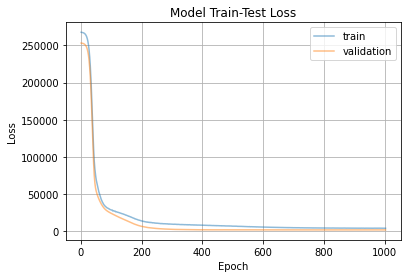

In [15]:
# Train and val Loss
if params.is_train:
    loss_fig = plt.figure()
    loss_title = 'Model Train-Test Loss'

    loss_fig = plt.figure()
    plt.plot(np.arange(1, len(train_loss) + 1), train_loss,label="train", alpha=0.5)
    plt.plot(np.arange(1, len(val_loss) + 1), val_loss,label="validation", alpha=0.5)
    plt.title(loss_title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
if params.is_save:
    if not isinstance(N_STEPS_AHEAD, list):
        n_steps_arr = [N_STEPS_AHEAD]
    else:
        n_steps_arr = N_STEPS_AHEAD
    for n_step in n_steps_arr:
        # Update params
        params.get_params_name(SUBJECT, n_step, update=True)
        if params.is_train:
            # Store model weights
            model.save_weights(params.CHECKPOINT_PATH)
            print(f"Successfully save weights in {params.CHECKPOINT_PATH}")

Successfully save weights in ../checkpoints/FovSOS-FSD_sacc_20/SUBJECT_s613-tIMG_natural-N_1-Nt_5-SEQ_10-InUts_30-LR_0.0001-EPOCHS_5000-PAT_150/checkpoint


# Results

In [17]:
process_functions_prediction = [
    {
        "process_fn": process_foveatedImg,
        "kwargs": {
            "load_features": False,
            "pretrained_model_fn": SALICONtf,
            "pretrained_model_kwargs": {
                "salicon_weights": "../checkpoints/SALICON/model_lr0.01_loss_crossentropy.h5",
                "vgg16_weights": "../checkpoints/SALICON/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
            },
            "feature_selectors": data_processor.get_feature_selectors()
        }
    }
]

In [18]:
_, _, imgs_test = data_processor.get_img_names()
scaler = data_processor.get_scaler()

In [19]:
y_pred_dict = prediction_n_step(
                    model=model, 
                    X_test=X_test,
                    scaler=scaler, 
                    n_steps_ahead=N_STEPS_AHEAD,
                    imgs_test=imgs_test,
                    process_functions=process_functions_prediction
)
y_real_dict = create_real_dict(y_real=y_test, n_steps_ahead=N_STEPS_AHEAD)

Making prediction of image 11: 100%|████████████| 12/12 [00:00<00:00, 18.81it/s]


In [20]:
if params.N_MC_SAMPLES:
    mcdropout_mean_dict, mcdropout_std_dict = model_mc_dropout(
                                                    model=model, 
                                                    X_test=X_test, 
                                                    scaler=scaler_x, 
                                                    n_steps_ahead=N_STEPS_AHEAD, 
                                                    n_mc_samples=params.N_MC_SAMPLES,
                                                    imgs_test=imgs_test,
                                                    process_functions=process_functions_prediction
                                            )

In [21]:
if params.N_MC_SAMPLES:
    y_real_dict, y_pred_dict, mcdropout_mean_dict, mcdropout_std_dict = adjust_indexes(
        y_real_dict=y_real_dict, 
        y_pred_dict=y_pred_dict, 
        n_steps_ahead=N_STEPS_AHEAD, 
        mcdropout_dicts=[mcdropout_mean_dict, mcdropout_std_dict])
else:
    y_real_dict, y_pred_dict = adjust_indexes(
        y_real_dict=y_real_dict, 
        y_pred_dict=y_pred_dict, 
        n_steps_ahead=N_STEPS_AHEAD) 

In [22]:
if not isinstance(N_STEPS_AHEAD, list):
    n_steps_arr = [N_STEPS_AHEAD]
else:
    n_steps_arr = N_STEPS_AHEAD
for n_step in n_steps_arr:
    # Update params
    params.get_params_name(SUBJECT, n_step, update=True)

    # Store results
    y_real_concat = pd.concat(y_real_dict[n_step])
    save_kwargs = {
        "y_pred": pd.concat(y_pred_dict[n_step]),
        "y_real": y_real_concat,
        "idx": y_real_concat.index
    }
    if params.is_train:
        save_kwargs = {
            **save_kwargs,
            **{
                "train_loss": train_loss,
                "val_loss": val_loss
            }
        }
    if params.N_MC_SAMPLES:
        save_kwargs = {
            **save_kwargs, 
        **{
            "mcdropout_mean": pd.concat(mcdropout_mean_dict[n_step]),
            "mcdropout_std": pd.concat(mcdropout_std_dict[n_step]),
        }
        }
    if params.is_save:
        np.savez(os.path.join(params.SAVE_FOLDER, f"{params.labels_params.TRAIN_IMG_TYPE}.npz"), 
            **save_kwargs)
        print("SAVED", params.labels_params.TRAIN_IMG_TYPE)

SAVED natural


In [23]:
# Params
n_step = 1

In [24]:
y_real = y_real_dict[n_step][0]
y_pred = y_pred_dict[n_step][0]
if params.N_MC_SAMPLES:
    mcdropout_mean = mcdropout_mean_dict[n_step][0]
    mcdropout_std = mcdropout_std_dict[n_step][0]

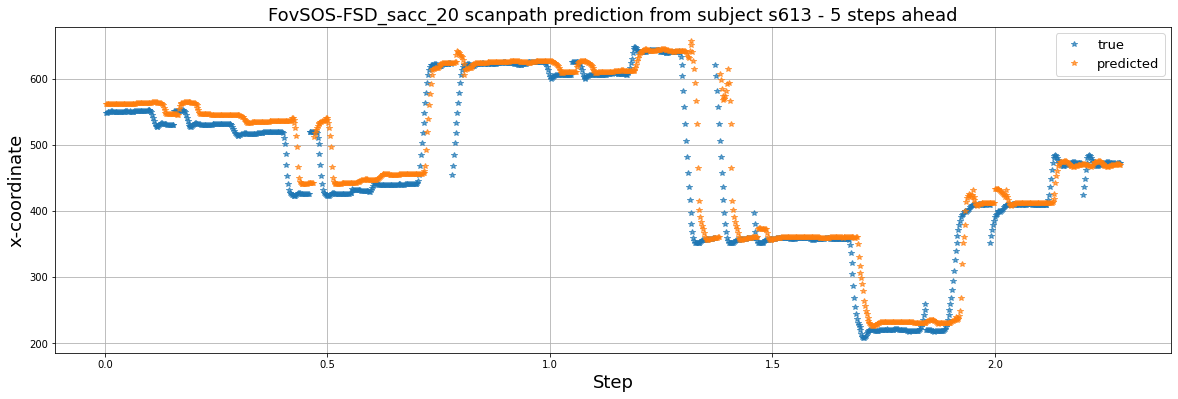

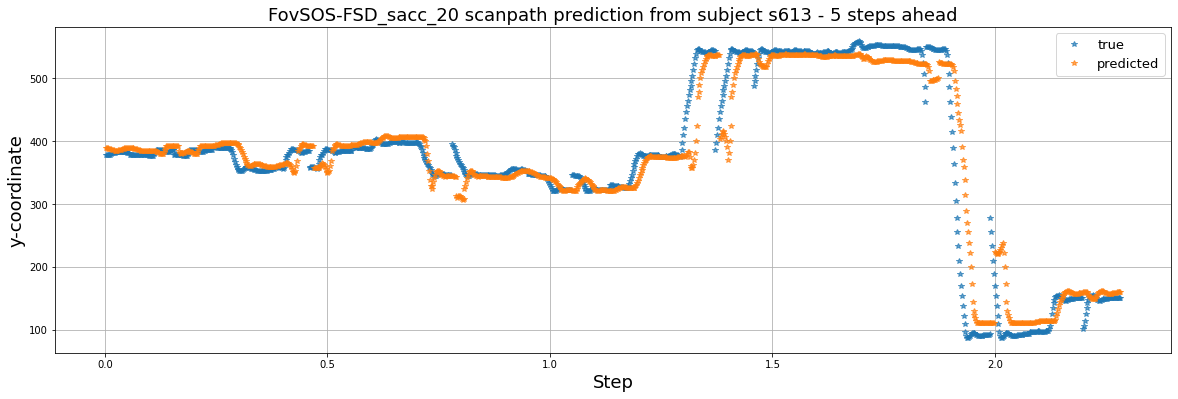

In [25]:
for x_or_y in ["x", "y"]:
    plt.figure(figsize=(20,6))
    plt.plot(y_real[x_or_y].index*2/1000, y_real[x_or_y], 'C0*', label='true', alpha=0.7)
    plt.plot(y_pred[x_or_y].index*2/1000, y_pred[x_or_y], 'C1*', label='predicted', alpha=0.7)
    # Plot mean std
    if params.N_MC_SAMPLES:
        plt.fill_between(y_real[x_or_y].index*2/1000, mcdropout_mean[x_or_y] - 3*mcdropout_std[x_or_y],
                     mcdropout_mean[x_or_y] + 3*mcdropout_std[x_or_y], color='C2', alpha=0.4)
    # Plot percentile
    #plt.plot(np.percentile(lstm_mcdropout_pred, q=percentile, axis=0)[:, 0 if x_or_y == "x" else 1],'C3', label=f'Percentile {percentile}', alpha=0.7)

    plt.legend(loc='best', prop={'size': 13})
    if params.N_MC_SAMPLES:
        title = f'{model_name} with MC-Dropout scanpath prediction from subject {SUBJECT} - {HORIZON} steps ahead'
    else:
        title = f'{model_name} scanpath prediction from subject {SUBJECT} - {HORIZON} steps ahead'
    plt.title(title, fontsize=18)
    plt.grid()
    plt.ylabel(f"{x_or_y}-coordinate", fontsize=18)
    plt.xlabel("Step", fontsize=18)
    #plt.xlim(1100, 1440)
    #plt.xlim(700, 750)
    #plt.xlim(3.2, 3.5)
    plt.show()

In [26]:
if test_on_rest_images:
    for img_type in params.get_rest_img_types(): 
        print(f"Testing on {img_type} images:")
        if f"{img_type}.npz" in os.listdir(params.SAVE_FOLDER):
            print(f"{img_type} predictions already calculated and stored, continue..")
            continue
        process_kwargs["post_process_kwargs"]["feature_selectors"] = data_processor.get_feature_selectors()
        # Load data
        if return_split_test:
            (_, _), (_, _), (X_gens_test, y_gens_test) = data_processor.run(
                img_type, 
                return_split=return_split_test,
                process_functions=process_functions,
                kwargs=process_kwargs
            )
        else:
            X_gens_test, y_gens_test = data_processor.run(
                img_type, 
                return_split=False,
                process_functions=process_functions,
                kwargs=process_kwargs
            )
        process_functions_prediction_test = [
            {
                "process_fn": process_foveatedImg,
                "kwargs": {
                    "load_features": False,
                    "pretrained_model_fn": SALICONtf,
                    "pretrained_model_kwargs": {
                        "salicon_weights": "../checkpoints/SALICON/model_lr0.01_loss_crossentropy.h5",
                        "vgg16_weights": "../checkpoints/SALICON/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
                    },
                    "feature_selectors": data_processor.get_feature_selectors()
                }
            }
        ]
        if return_split_test:
            _, _, imgs = data_processor.get_img_names(return_split=return_split_test)
        else:
            imgs = data_processor.get_img_names(return_split=return_split_test)

        scaler = data_processor.get_scaler()
        # Prediction
        y_pred_dict_test = prediction_n_step(model=model, 
                                            X_test=X_gens_test,
                                            scaler=scaler, 
                                            n_steps_ahead=N_STEPS_AHEAD,
                                            imgs_test=imgs,
                                            process_functions=process_functions_prediction_test
                                            )
        y_real_dict_test = create_real_dict(y_real=y_gens_test, n_steps_ahead=N_STEPS_AHEAD)

        if params.N_MC_SAMPLES:
            # MC Dropout Prediction
            mcdropout_mean_dict_test, mcdropout_std_dict_test = model_mc_dropout(
                model=model, 
                X_test=X_gens_test, 
                scaler=scaler_x, 
                n_steps_ahead=N_STEPS_AHEAD, 
                n_mc_samples=params.N_MC_SAMPLES,
                imgs_test=imgs,
                process_functions=process_functions_prediction_test
            )
        if params.N_MC_SAMPLES:
            y_real_dict_test, y_pred_dict_test, mcdropout_mean_dict_test, mcdropout_std_dict_test = adjust_indexes(
                y_real_dict=y_real_dict_test, 
                y_pred_dict=y_pred_dict_test, 
                n_steps_ahead=N_STEPS_AHEAD, 
                mcdropout_dicts=[mcdropout_mean_dict_test, mcdropout_std_dict_test])
        else:
            y_real_dict_test, y_pred_dict_test = adjust_indexes(
                y_real_dict=y_real_dict_test, 
                y_pred_dict=y_pred_dict_test, 
                n_steps_ahead=N_STEPS_AHEAD) 
        for n_step in N_STEPS_AHEAD:
            # Update params
            params.get_params_name(SUBJECT, n_step, update=True)
            y_real_concat_test = pd.concat(y_real_dict_test[n_step])
            save_kwargs = {
                "y_pred": pd.concat(y_pred_dict_test[n_step]),
                "y_real": y_real_concat_test,
                "idx": y_real_concat_test.index
            }
            if params.N_MC_SAMPLES:
                save_kwargs = {**save_kwargs, 
                            **{
                                "mcdropout_mean": pd.concat(mcdropout_mean_dict_test[n_step]),
                                "mcdropout_std": pd.concat(mcdropout_std_dict_test[n_step]),
                            }}
            if params.is_save:
                np.savez(os.path.join(params.SAVE_FOLDER, f"{img_type}.npz"), 
                    **save_kwargs)
                print("SAVED", img_type)